In [1]:
from molmap import loadmap
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import KFold

import warnings, os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm


warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
def CalcFeatImp(model, mp, arrX, dfY, task_type = 'classification', sigmoidy = False):
    '''
    Forward prop. Feature importance
    '''
    
    if task_type == 'classification':
        f = log_loss
    else:
        f = mean_squared_error
        
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    grid = mp.plot_grid()
    Y_true = dfY.values
    df_grid = mp.df_grid.sort_values(['y', 'x']).reset_index(drop=True)
    Y_prob = model.predict(arrX)
    N, W, H, C = arrX.shape
    
    if (sigmoidy) & (task_type == 'classification'):
        Y_prob = sigmoid(Y_prob)

    final_res = {}
    for k, col in enumerate(dfY.columns):
        print('calculating feature importance for %s ...' % col)
        
        results = []
        loss = f(Y_true[:, k].tolist(), Y_prob[:, k].tolist())
        for i in tqdm(range(len(df_grid)), ascii= True):
            ts = df_grid.iloc[i]
            y = ts.y
            x = ts.x
            X1 = copy(arrX)
            X1[:, y, x,:] = np.full(X1[:, y, x,:].shape, fill_value = arrX.min())
            #Y1 = model.predict(X1)
            Y_pred_prob = model.predict(X1)
            if (sigmoidy) & (task_type == 'classification'):
                Y_pred_prob = sigmoid(Y_pred_prob)
            mut_loss = f(Y_true[:, k].tolist(), Y_pred_prob[:, k].tolist()) 
            res =  mut_loss - loss # if res > 0, important, othervise, not important
            results.append(res)
            
        final_res.update({col:results})
    df = pd.DataFrame(final_res)
    df.columns = df.columns + '_importance'
    df = df_grid.join(df)
    return df

In [3]:
dfx  = pd.read_excel('./COVID19.xlsx', sheet_name='data')
dfy  = pd.read_excel('./COVID19.xlsx', sheet_name='sample_info')

dfx = dfx[dfx.columns[1:]]
cols = ["p-%s" % c for c in dfx.columns]
dfx.columns = cols

X = dfx.values
Y = pd.get_dummies(dfy['class']).values.astype(float)

In [4]:
mp = loadmap('./saved_model/aggmap.mp')

In [5]:
repeat_seed = 8
outer_fold = 4
outer = KFold(n_splits = outer_fold, shuffle = True, random_state = repeat_seed)
outer_idx = outer.split(range(len(Y)), Y[:,0])

all_importance = {}
for i, idx in enumerate(outer_idx):

    fold_num = "fold_%s" % str(i).zfill(2) 

    train_idx, test_idx = idx

    testY = Y[test_idx]
    testx = X[test_idx]

    trainx = X[train_idx]
    trainY = Y[train_idx]

    trainX = mp.batch_transform(trainx, scale_method = 'standard')
    testX = mp.batch_transform(testx, scale_method = 'standard')

    model_name = './saved_model/seed_8-%s.h5' % fold_num
    model = load_model(model_name)

    arrX = trainX
    dfY = pd.DataFrame(trainY, columns = pd.get_dummies(dfy['class']).columns)

    df_imp = CalcFeatImp(model, mp, arrX, dfY, task_type = 'classification', sigmoidy = False)
    all_importance.update({fold_num: df_imp})


100%|##########| 91/91 [00:00<00:00, 1900.45it/s]


2020-10-26 23:24:49,030 - INFO - [bidd-aggmap] - generate file: ./feature points_88_correlation_umap_mp
2020-10-26 23:24:49,048 - INFO - [bidd-aggmap] - save html file to ./feature points_88_correlation_umap_mp


  3%|3         | 3/90 [00:00<00:04, 21.36it/s]

calculating feature importance for COVID-19 ...


  3%|3         | 3/90 [00:00<00:03, 22.49it/s]

calculating feature importance for Control ...


100%|##########| 91/91 [00:00<00:00, 1943.23it/s]


2020-10-26 23:25:00,840 - INFO - [bidd-aggmap] - generate file: ./feature points_88_correlation_umap_mp
2020-10-26 23:25:00,853 - INFO - [bidd-aggmap] - save html file to ./feature points_88_correlation_umap_mp


  0%|          | 0/90 [00:00<?, ?it/s]

calculating feature importance for COVID-19 ...


  3%|3         | 3/90 [00:00<00:03, 21.80it/s]

calculating feature importance for Control ...


100%|##########| 90/90 [00:00<00:00, 1719.31it/s]


2020-10-26 23:25:10,673 - INFO - [bidd-aggmap] - generate file: ./feature points_88_correlation_umap_mp
2020-10-26 23:25:10,686 - INFO - [bidd-aggmap] - save html file to ./feature points_88_correlation_umap_mp


  0%|          | 0/90 [00:00<?, ?it/s]

calculating feature importance for COVID-19 ...


  3%|3         | 3/90 [00:00<00:03, 22.97it/s]

calculating feature importance for Control ...


100%|##########| 90/90 [00:00<00:00, 1660.83it/s]


2020-10-26 23:25:20,272 - INFO - [bidd-aggmap] - generate file: ./feature points_88_correlation_umap_mp
2020-10-26 23:25:20,288 - INFO - [bidd-aggmap] - save html file to ./feature points_88_correlation_umap_mp


  0%|          | 0/90 [00:00<?, ?it/s]

calculating feature importance for COVID-19 ...


  3%|3         | 3/90 [00:00<00:03, 21.83it/s]

calculating feature importance for Control ...


100%|##########| 90/90 [00:04<00:00, 22.02it/s]


In [6]:
results = []
for k, v in all_importance.items():
    ts = v[['COVID-19_importance']]
    ts.columns =  [k]
    results.append(ts)
dfi = pd.concat(results, axis=1)
#dfi.columns = 'seed_%s-' % seed + dfi.columns

In [7]:
sns.set(style='white',  font='sans-serif', font_scale=1.8)

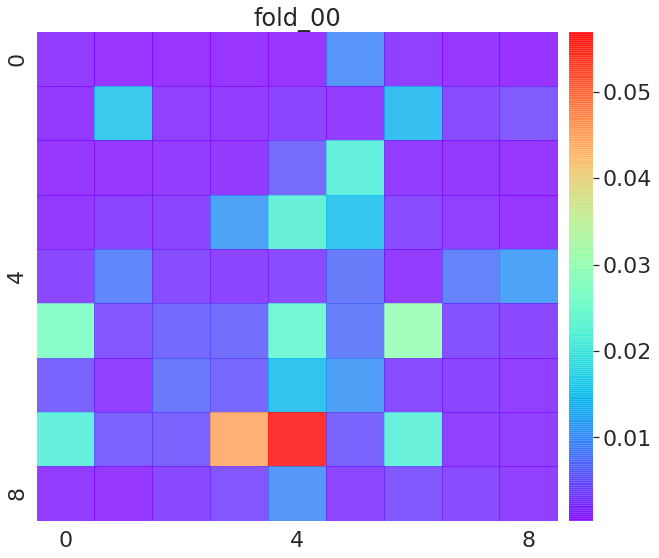

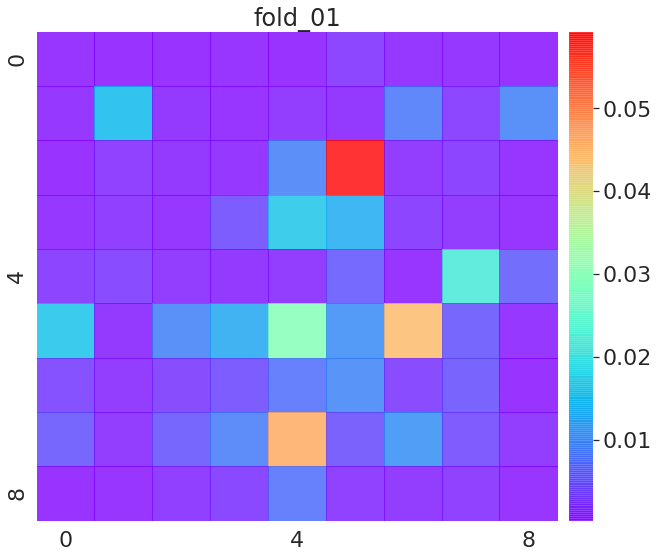

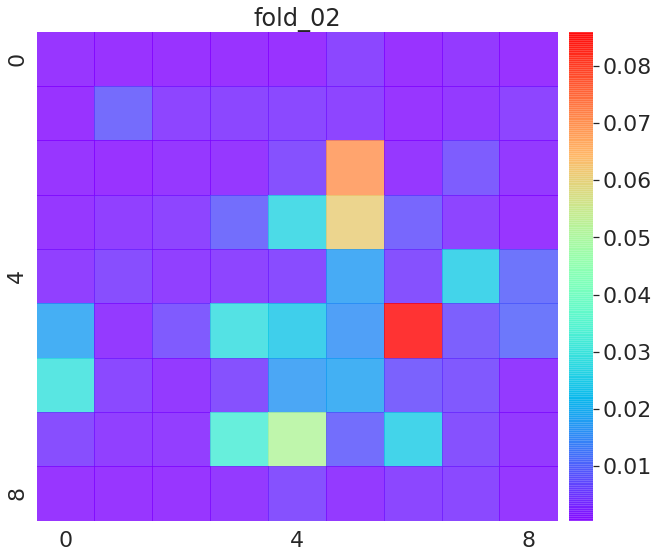

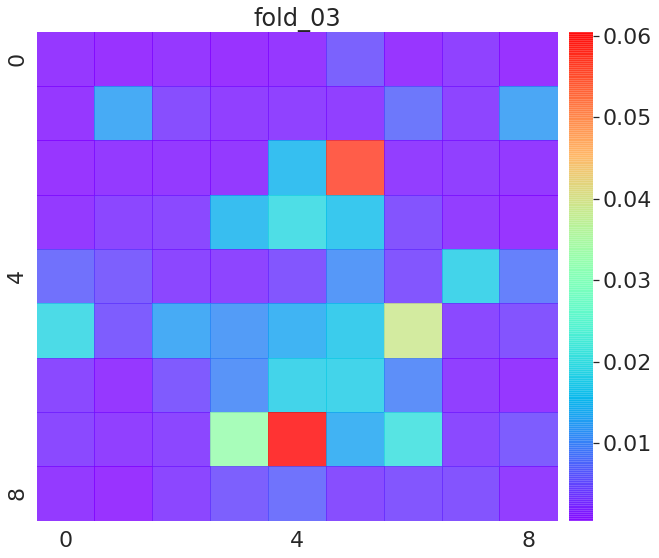

In [8]:
for country in dfi.columns:    
    sns.set(style='white',  font='sans-serif', font_scale=2)
    fig, ax  = plt.subplots(1, 1, figsize=(10, 9))

    IMPM = dfi[country].values.reshape(*mp.fmap_shape)
    sns.heatmap(IMPM,  
                cmap = 'rainbow', alpha = 0.8, xticklabels=4, ax =ax,
                yticklabels=4, #vmin = -7,
                cbar_kws = {'fraction':0.046, 'pad':0.02})

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.title(country)

    plt.subplots_adjust(wspace = 0.18)

    plt.savefig('./saved_model/%s.svg' % country, dpi = 400, bbox_inches="tight")


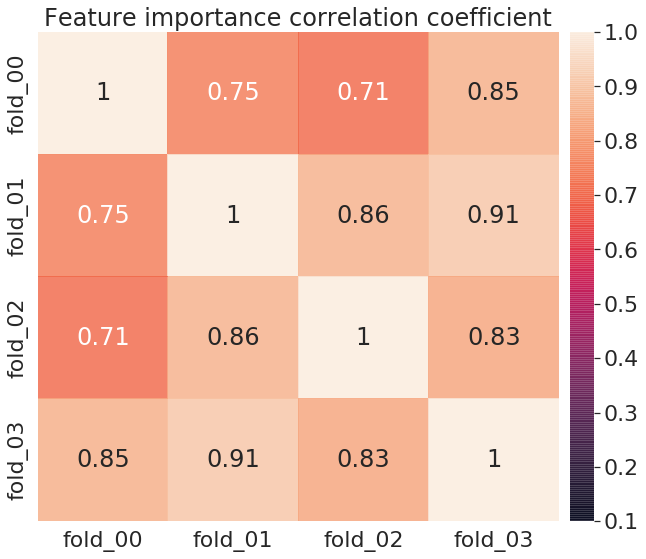

In [9]:

fig, ax  = plt.subplots(1, 1, figsize=(10, 9))

IMPM = dfi.corr()
sns.heatmap(IMPM,  
            yticklabels = IMPM.columns, # xticklabels=4,yticklabels=4,
            xticklabels = IMPM.columns,
             alpha = 0.8, ax =ax, #cmap = 'hot',
            vmin = 0.1, annot = True, #va="center",
            cbar_kws = {'fraction':0.046, 'pad':0.02})


ax.set_title("Feature importance correlation coefficient")
pos, textvals = plt.yticks()
plt.yticks(pos,IMPM.index,  va="center")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


plt.savefig('./saved_model/all.png', dpi = 400, bbox_inches="tight")

In [20]:

df_save = all_importance['fold_00'][['x', 'y', 'v', 'Subtypes', 'colors', ]].join(dfi)
df_save = df_save.set_index('v')
df_save['average_importance'] = dfi.mean(axis=1).values
df_save = df_save.sort_values('average_importance', ascending = False)
df_save = df_save[df_save.index != 0]

df_save.to_excel('./saved_model/feature_importance.xlsx')
f = df_save.head(20)[['x', 'y',  'Subtypes', 'average_importance']]


In [11]:
from statannot import add_stat_annotation

cols = f.index.tolist()[:10]


all_data = []
for col in cols:
    x = dfx[col]
    dfd = x.to_frame(name = 'Intensity').join(dfy['class'].to_frame(name = 'Group'))
    dfd['peak'] = col
    all_data.append(dfd)

In [12]:
data = pd.concat(all_data, axis=0)
y  = 'Intensity'
hue = 'Group' 
x = 'peak'

box_pairs = [((col, "COVID-19"), (col, "Control")) for col in cols]
#****P < 0.0001 by two-tailed Wilcoxon rank sum test.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

p-4138_COVID-19 v.s. p-4138_Control: Mann-Whitney-Wilcoxon test two-sided, P_val=1.009e-05 U_stat=1.160e+04
p-3609_COVID-19 v.s. p-3609_Control: Mann-Whitney-Wilcoxon test two-sided, P_val=4.307e-01 U_stat=1.516e+04
p-8215_COVID-19 v.s. p-8215_Control: Mann-Whitney-Wilcoxon test two-sided, P_val=7.906e-05 U_stat=1.981e+04
p-7654_COVID-19 v.s. p-7654_Control: Mann-Whitney-Wilcoxon test two-sided, P_val=4.795e-03 U_stat=1.316e+04
p-6361_COVID-19 v.s. p-6361_Control: Mann-Whitney-Wilcoxon test two-sided, P_val=8.122e-03 U_stat=1.333e+04
p-3044_COVID-19 v.s. p-3044_Control: Mann-Whitney-Wilcoxon test two-sided, P_val=1.079e-06 U_stat=1.114e+04
p-8568_COVID-19 v.s. p-8568_Control: Mann-Whitney-Wilcoxon test two-sided, P_val=4.872e-01 U_stat=1.525e+04
p-7612_COVID-19 v.s. p-7612_Control: Mann-Whitney-Wilcoxon test two-sided, P_val

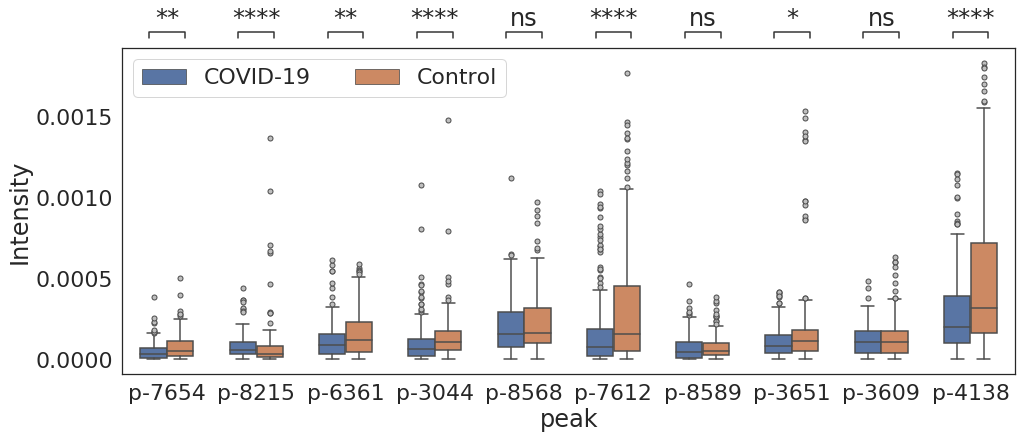

In [13]:
fig, ax  = plt.subplots(1, 1, figsize=(16, 6))

# g = sns.stripplot(x=x, y=y, hue = hue, data=data, color= ".2", order = cols, ax= ax, size = 6,
#                    split=True,  jitter=True, linewidth=1, edgecolor='gray') #palette="Set2",palette = [".8", ".8"]
    
flierprops = dict(marker = 'o',markerfacecolor='0.75', markersize=5, linestyle='none')
    
sns.boxplot(data = data,y=y, x = x, hue = hue,  width = 0.6, ax = ax, order = cols, flierprops = flierprops) # palette="Set1_r", 

ax, test_results = add_stat_annotation(ax, data=data, x=x, y=y, hue = hue, test='Mann-Whitney', 
                                       box_pairs=box_pairs,comparisons_correction=None,
                                       text_format='star', loc='outside', verbose=2)


plt.legend(loc='upper left', #bbox_to_anchor=(0.5, -0.1),
          fancybox=True,  ncol=2)


plt.savefig('example_non-hue_outside.png', dpi=300, bbox_inches='tight')

In [14]:
import pylab as plt
from matplotlib_venn import venn2

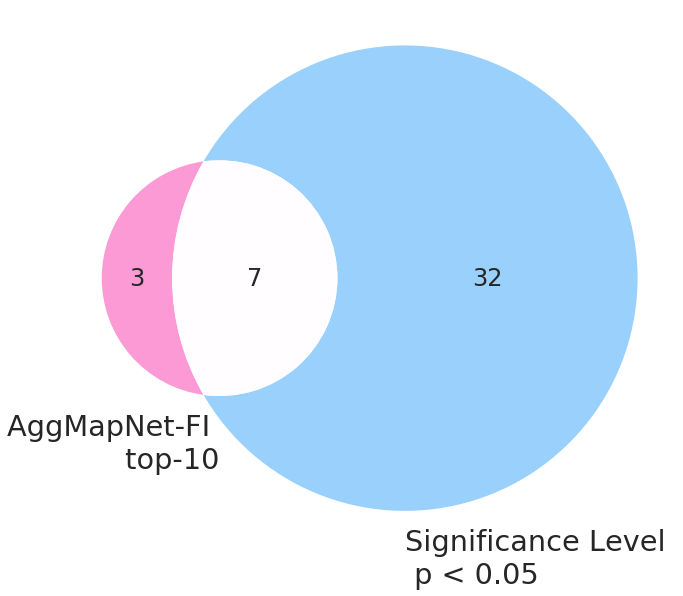

<Figure size 432x288 with 0 Axes>

In [15]:
s = df_save.head(10)
aggmapfi = s.index.map(lambda x:int(x.split('-')[1])).tolist()
significant = pd.read_csv('./select_p_value_sig.txt', header = None)[0].tolist()
fig, ax  = plt.subplots(1, 1, figsize=(16, 10))

venn2(subsets = (set(aggmapfi), set(significant)), 
      set_labels = ('AggMapNet-FI \n top-10', 'Significance Level\n p < 0.05'), 
      normalize_to =1.2,ax = ax,
      alpha=1, set_colors=('#fc9ad5','#9ad0fc'))
plt.show()
plt.savefig('10.png', dpi=300, bbox_inches='tight')

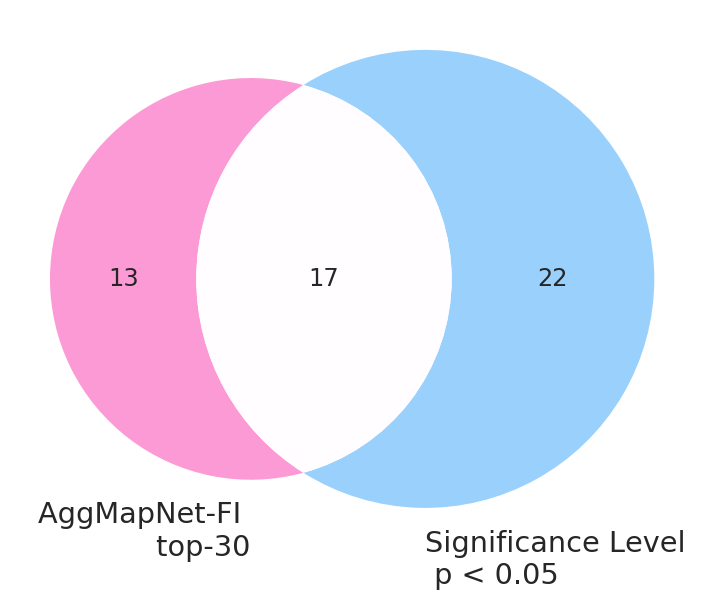

<Figure size 432x288 with 0 Axes>

In [16]:
s = df_save.head(30)
aggmapfi = s.index.map(lambda x:int(x.split('-')[1])).tolist()
significant = pd.read_csv('./select_p_value_sig.txt', header = None)[0].tolist()
fig, ax  = plt.subplots(1, 1, figsize=(16, 10))

venn2(subsets = (set(aggmapfi), set(significant)), 
      set_labels = ('AggMapNet-FI \n top-30', 'Significance Level\n p < 0.05'), 
      normalize_to =1.2,ax = ax,
      alpha=1, set_colors=('#fc9ad5','#9ad0fc'))
plt.show()
plt.savefig('30.png', dpi=300, bbox_inches='tight')

In [17]:
cols = ['p-7654', 'p-11735',
 'p-8215',
 'p-6361',
 'p-3044',
 'p-8568',
 'p-7612',
 'p-8589',
 'p-3651',
 'p-3609',
 'p-4138']


In [18]:
dfx[cols].corr()

,p-7654,p-11735,p-8215,p-6361,p-3044,p-8568,p-7612,p-8589,p-3651,p-3609,p-4138
p-7654,1.000000,0.183902,0.092081,-0.242943,0.214032,0.200445,0.447444,0.241468,-0.071107,-0.033283,-0.168595
p-11735,0.183902,1.000000,0.076583,-0.003892,-0.089462,0.159507,0.293775,0.151975,-0.210715,0.051281,-0.196509
p-8215,0.092081,0.076583,1.000000,-0.125601,-0.030052,0.146436,0.031019,0.133821,-0.067279,-0.017300,-0.116761
p-6361,-0.242943,-0.003892,-0.125601,1.000000,-0.049853,-0.107135,-0.107504,-0.130402,-0.175146,0.319807,0.347251
p-3044,0.214032,-0.089462,-0.030052,-0.049853,1.000000,0.033661,0.036105,0.094145,0.081573,-0.006614,-0.116312
p-8568,0.200445,0.159507,0.146436,-0.107135,0.033661,1.000000,0.079045,0.729181,-0.030652,-0.031987,0.028166
p-7612,0.447444,0.293775,0.031019,-0.107504,0.036105,0.079045,1.000000,0.112598,-0.129861,0.109323,0.040294
p-8589,0.241468,0.151975,0.133821,-0.130402,0.094145,0.729181,0.112598,1.000000,-0.077611,-0.045286,-0.129899
p-3651,-0.071107,-0.210715,-0.067279,-0.175146,0.081573,-0.030652,-0.129861,-0.077611,1.000000,-0.014421,-0.078802
p-3609,-0.033283,0.051281,-0.017300,0.319807,-0.006614,-0.031987,0.109323,-0.045286,-0.014421,1.000000,0.200863


In [22]:
dfy

,sample,lab,class
0,lab1-P1,lab-1,COVID-19
1,lab1-P2,lab-1,COVID-19
2,lab1-P3,lab-1,COVID-19
3,lab1-P4,lab-1,COVID-19
4,lab1-P5,lab-1,COVID-19
...,...,...,...
357,lab3-N13,lab-3,Control
358,lab3-N14,lab-3,Control
359,lab3-N15,lab-3,Control
360,lab3-N16,lab-3,Control


In [33]:
from scipy.stats import mannwhitneyu
p_values = []
for c in df_save.index:
    if c != 0:
        v1 = dfx[[c]]
        v2 = dfy[['class']]
        xx = v1.join(v2).groupby('class')[c].apply(lambda x:x.to_list())    
        s, p = mannwhitneyu(xx[0], xx[1], alternative='two-sided')
        p_values.append(p)
    else:
        p_values.append(None)


In [35]:
df_save['mannwhitneyu_p-value'] = p_values
df_save.to_excel('./saved_model/feature_importance.xlsx')